## Class 11

## Mar. 25, 2024

By the end of this class, you'll be able to:

- Load in spatial data

- Join geodataframes with attribute tables

- Plot maps in multiple ways

- Get some knowledge about clustering (will talk about it next week!)

In [ ]:
# ## Let's install and then load libraries
# %pip install geopandas
# %pip install mapclassify
# %pip install contextily
# %pip install libpysal
# %pip install esda
# %pip install splot
# %pip install xlrd
# %pip install numba==0.53

In [6]:
# Let's start with importing the packages

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
#import mapclassify
#import esda
##import splot
#import libpysal as lps
#import contextily as cx
#import xlrd

## A review of spatial data and mapping

### Let's bring in the same files we worked with last week

We'll be working with the Toronto Neighbourhoods spatial data and the health data today:
- `Toronto_Neighbourhoods.geojson`

- `1_ahd_neighb_db_ast_hbp_mhv_copd_2007.xls`

### 1. Using GeoPandas to load in spatial data

In [ ]:
nbrhd = gpd.GeoDataFrame.from_file("Toronto_Neighbourhoods.geojson")

The content of the spatial data

In [ ]:
nbrhd.head(2)

What is geometry?

In [ ]:
first_neighbor = nbrhd.loc[0,'geometry']
print(first_neighbor)

In [ ]:
first_neighbor

Another example of geometry

In [ ]:
rails =  gpd.GeoDataFrame.from_file("toronto_rails.geojson")
print(rails.loc[0,'geometry'])

In [3]:
first_rail_points = [(-79.5125670999999,43.814361500000075),
                    (-79.51253669999994, 43.81447250000008),
                    (-79.512524, 43.81452850000005),
                    (-79.51251939999992,43.814607),
                    (-79.51251739999992,43.814716900000064),
                    (-79.51252729999993,43.814817),
                    (-79.51254659999995,43.81492840000004),
                    (-79.51261019999993,43.815184800000054),
                    (-79.51270719999991,43.815575100000046), 
                    (-79.51291559999993,43.816454400000055), 
                    (-79.51339439999992,43.81834120000008), 
                    (-79.51371579999994,43.819633), 
                    (-79.513803,43.820002), 
                    (-79.51385459999995, 43.82019790000004), 
                    (-79.51389059999991, 43.820318), 
                    (-79.51392659999993, 43.82045130000006),]
x, y = zip(* first_rail_points)
x

(-79.5125670999999,
 -79.51253669999994,
 -79.512524,
 -79.51251939999992,
 -79.51251739999992,
 -79.51252729999993,
 -79.51254659999995,
 -79.51261019999993,
 -79.51270719999991,
 -79.51291559999993,
 -79.51339439999992,
 -79.51371579999994,
 -79.513803,
 -79.51385459999995,
 -79.51389059999991,
 -79.51392659999993)

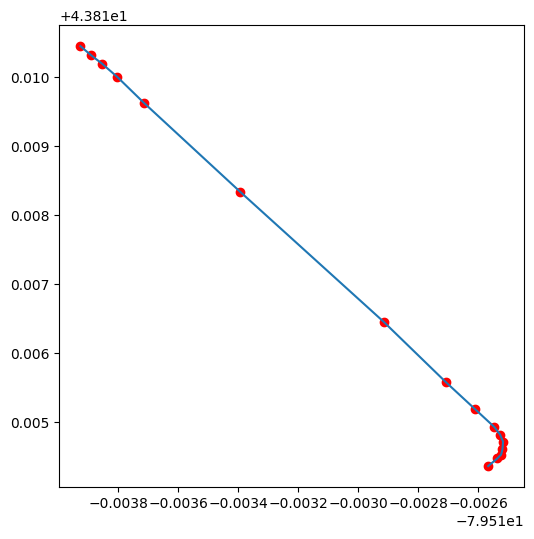

In [4]:
fig, axes = plt.subplots(1, 1, figsize = (6,6))

plt.plot(x,y)
plt.scatter(x, y, c='red');

In [5]:
rails.loc[0,'geometry']

NameError: name 'rails' is not defined

Note: the difference between plotting on Cartesian coordinate system and plotting as a geo-object comes from the different coordination reference system (CRS) used by the GeoDataFrame.

In [ ]:
rails.crs

Therefore, a `GeoDataframe` can be understood as a `GeoSeries` with several `DataFrame` `Series`.

![figure](dataframe.svg)

### 2. Simplify the geodataframe

In [ ]:
nbrhd.columns

In [ ]:
nbrhd.head(2)

In [ ]:
# important columns
important_spat_cols = nbrhd.columns[[4, 5, 17]]
important_spat_cols

In [ ]:
# rename dictionary
colnames_spat = {important_spat_cols[0]: 'nbrhd_name',
           important_spat_cols[1] : 'nbrhd_spat_id',
           important_spat_cols[2] : 'geometry'}
colnames_spat

In [ ]:
# Selec the important columns
nbrhd_simple = nbrhd.copy()
nbrhd_simple = nbrhd_simple[important_spat_cols]
nbrhd_simple.rename(columns = colnames_spat, inplace=True)
nbrhd_simple.head()

### 3. Import health information and simplify it

In [7]:
fname = '1_ahd_neighb_db_ast_hbp_mhv_copd_2007.xls' #file name
sname = '1_ahd_neighb_asthma_2007' #sheet name in excel file

#store excel sheet with asthma data in a dataframe variable
asthma_neighb = pd.read_excel(fname, sheet_name = sname, header = 11)

In [8]:
asthma_neighb.head(2)

,Unnamed: 0,Unnamed: 1,Demographics ª,% With asthma,LL (95% CI),UL (95% CI),Demographics ª.1,% With asthma.1,LL (95% CI) .1,UL (95% CI) .1,...,Demographics ª.7,% With asthma.7,LL (95% CI) .7,UL (95% CI) .7,Demographics ª.8,% With asthma.8,LL (95% CI) .8,UL (95% CI) .8,Rate Ratio**.2,H/L/NS.2
0,1,West Humber-Clairville,11977,9.7,9.2,10.2,11770,10.6,10.0,11.2,...,4435,12.3,11.3,13.3,8921,10.9,10.3,11.6,1.07,H
1,2,Mount Olive-Silverstone-Jamestown,11157,7.9,7.4,8.4,11462,10.2,9.6,10.8,...,3819,13.5,12.5,14.6,7726,11.2,10.5,11.9,1.10,H


In [9]:
asthma_neighb.columns

Index(['Unnamed: 0', 'Unnamed: 1', 'Demographics ª', '% With asthma',
       'LL (95% CI) ', 'UL (95% CI) ', 'Demographics ª.1', '% With asthma.1',
       'LL (95% CI) .1', 'UL (95% CI) .1', 'Demographics ª.2',
       '% With asthma.2', 'LL (95% CI) .2', 'UL (95% CI) .2', 'Rate Ratio**',
       'H/L/NS', 'Demographics ª.3', '% With asthma.3', 'LL (95% CI) .3',
       'UL (95% CI) .3', 'Demographics ª.4', '% With asthma.4',
       'LL (95% CI) .4', 'UL (95% CI) .4', 'Demographics ª.5',
       '% With asthma.5', 'LL (95% CI) .5', 'UL (95% CI) .5', 'Rate Ratio**.1',
       'H/L/NS.1', 'Demographics ª.6', '% With asthma.6', 'LL (95% CI) .6',
       'UL (95% CI) .6', 'Demographics ª.7', '% With asthma.7',
       'LL (95% CI) .7', 'UL (95% CI) .7', 'Demographics ª.8',
       '% With asthma.8', 'LL (95% CI) .8', 'UL (95% CI) .8', 'Rate Ratio**.2',
       'H/L/NS.2'],
      dtype='object')

In [10]:
# important columns
## Note: Instead of copying the column names, we can use the number to avoid any miscopies.
important_cols = asthma_neighb.columns[[0, 1, 10, 11]] 

# rename dictionary
colnames = {important_cols[0] : 'Neighbid', 
            important_cols[1] : 'name', 
            important_cols[2] : 'adult_pop',
            important_cols[3] : 'asthma_pct'}


In [11]:
# Select important columns
asthma_rates = asthma_neighb.copy()

asthma_rates = asthma_rates[important_cols]

asthma_rates.rename(columns = colnames, inplace=True)

asthma_rates.head()

,Neighbid,name,adult_pop,asthma_pct
0,1,West Humber-Clairville,23747,10.2
1,2,Mount Olive-Silverstone-Jamestown,22619,9.1
2,3,Thistletown-Beaumond Heights,6629,10.0
3,4,Rexdale-Kipling,6755,11.4
4,5,Elms-Old Rexdale,6588,11.6


### 4. Join our neighbourhood gdf with our asthma rate df:

check the neighborhood id type

In [ ]:
type(asthma_rates.loc[0,'Neighbid'])

In [ ]:
type(nbrhd_simple.loc[0,'nbrhd_spat_id'])

Convert our spatial ID from a string to a number before merge:

In [ ]:
#create a new variable in the nbrhd_simple geodataframe and store the new number
#version of the neighbourhood id here
nbrhd_simple["Neighbid"] = nbrhd_simple["nbrhd_spat_id"].astype(int)

nbrhd_simple.head()

In [ ]:
print(type(nbrhd_simple.loc[0,'nbrhd_spat_id']))
print(type(nbrhd_simple.loc[0,'Neighbid']))

Check the order of the neighborhood

In [ ]:
asthma_rates.head()

For the spatial data, we sort it by neighborhood id to check the consistency

In [ ]:
nbrhd_simple.sort_values('Neighbid').head()

In [ ]:
asthma_rates.tail()

In [ ]:
nbrhd_simple.sort_values('Neighbid').tail()

In [ ]:
# Usually we also want to check the number of the neighborhoods in both datasets
print("The number of neighborhoods in asthma dataset is: ", len(asthma_rates['Neighbid']))
print("The number of neighborhoods in neighborhood geo-dataset is: ", len(nbrhd_simple['Neighbid']))

Merge the data

In [ ]:
nbrhd_asthma = nbrhd_simple.merge(asthma_rates, on="Neighbid")
nbrhd_asthma.head()

#### Quick question
What if there are missing values in asthma dataset? That is, the number of neighborhood is less than the geodataframe?


In [ ]:
asthma_rates_temp = asthma_rates.loc[~asthma_rates['Neighbid'].isin([96,95,109])]
nbrhd_asthma_1 = nbrhd_simple.merge(asthma_rates_temp, on="Neighbid")
print(nbrhd_asthma_1.shape)
nbrhd_asthma_1.head()

In [ ]:
nbrhd_asthma_2 = nbrhd_simple.merge(asthma_rates_temp, on="Neighbid", how='left')
print(nbrhd_asthma_2.shape)
nbrhd_asthma_2.head()

In [ ]:
nbrhd_asthma_3 = nbrhd_simple.merge(asthma_rates_temp, on="Neighbid", how='right')
print(nbrhd_asthma_3.shape)
nbrhd_asthma_3.head()

#### Compare datum join (`df.merge`) with spatial join (`gdf.sjoin`)

In [ ]:
rails_simple = rails[['OBJECTID','geometry']]
rails_simple.plot()

In [ ]:
rails_simple = rails_simple.to_crs(nbrhd_simple.crs)
nbrhd_rail_1 = nbrhd_simple.sjoin(rails_simple) #default how = ‘inner’
nbrhd_rail_1.plot()

In [ ]:
nbrhd_rail_2 = nbrhd_simple.sjoin(rails_simple, how='left') 
# nbrhd_rail_2.plot()
nbrhd_rail_2.plot(column='OBJECTID')

In [ ]:
nbrhd_rail_2.head()

### 5. Map the attribute data (asthma)

We need to first set the "stage" of the figure.

Then we plot:

- the asthma rate (`column` = "asthma_pct"),

- in 5 quantiles (`scheme` = "quantiles", `k`=5),

- in the stage (`ax` = axes),

- with legend (`legend` = True).



In [ ]:
# First, let's create a figure variable "fig" and an axes variables called "ax".
# This code sets the stage - it says how many images - by rows/columns
# We can also set other figure attributes in here, like figure size using figsize

#import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 1, figsize = (12,12))

# Then plot the data with certain arguements:
# These two codes need to write in the same code, i.e., run simultaneously
nbrhd_asthma.plot(column='asthma_pct', scheme='quantiles', 
                  k=5, cmap='YlGn', edgecolor='grey', 
                  ax = axes, legend=True, 
                  legend_kwds={'loc': 4, 'title': 'Percent Asthmatic', 
                               'title_fontsize': 16,'fontsize': 12})

Make a figure with two maps side by side...

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (12,12))

# pick the first cell in the figure
nbrhd_asthma.plot(column = "name",
           ax=axes[0], cmap = "tab20")

# pick the second cell in the figure
nbrhd_asthma.plot(column = "asthma_pct",
           ax=axes[1], cmap = "YlGn")



### POP QUIZ!! 

1. How would we make a figure with 3 maps in 1 row? 
2. How would we make a figure with 3 maps in 1 **column**?
3. How would we make a figure with 6 maps in 3 rows and 2 columns? 

## More on Cartography

**To this point we have used quantiles to classify continous values in maps.**

**What other common options do we have?  See the document of [GeoDataFrame.plot](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.plot.html) and [mapclassify](https://github.com/pysal/mapclassify/tree/main)**

1. Equal Intervals
- This classification method "divides the data into equal size classes (e.g., 0-10, 10-20, 20-30, etc.) and works best on data that is generally spread across the entire range. **CAUTION**: Avoid equal interval if your data are skewed to one end or if you have one or two really large outlier values."

2. Natural Breaks
- This classification method "is a kind of “optimal” classification scheme that finds class breaks that will minimize within-class variance and maximize between-class differences." **However**, these breaks will be unique to each dataset and makes it difficult to compare across different maps. 


Before plot the variable, we usually want to see its distribution to see if certain classification can fit.

In [ ]:
nbrhd_asthma.asthma_pct.hist(bins=8)

Close to normal distribution, which means that the equal intervals should be fine.

Let's use the `scheme` parameter to the plot our asthma percentages using quartiles, equal intervals, and natural breaks. 

In [ ]:
fig, axes = plt.subplots(1,3, figsize =  (20,10))

nbrhd_asthma.plot(column='asthma_pct', scheme='Quantiles', 
                  k=4, cmap='YlOrRd', edgecolor='black', 
                  ax = axes[0], legend=True,                  
                  legend_kwds={'loc': 4, 'title': 'Percent Asthmatic', 
                               'title_fontsize': 8,'fontsize': 8})

nbrhd_asthma.plot(column='asthma_pct', scheme='EqualInterval', 
                  k=4, cmap='YlOrRd', edgecolor='black', 
                  ax = axes[1], legend=True,                  
                  legend_kwds={'loc': 4, 'title': 'Percent Asthmatic', 
                               'title_fontsize': 8,'fontsize': 8})

nbrhd_asthma.plot(column='asthma_pct', scheme='NaturalBreaks', 
                  k=4, cmap='YlOrRd', edgecolor='black', 
                  ax = axes[2], legend=True,                  
                  legend_kwds={'loc': 4, 'title': 'Percent Asthmatic', 
                               'title_fontsize': 8,'fontsize': 8})

axes[0].set_title("Quartiles", fontsize = 20)
axes[1].set_title("Equal Intervals", fontsize = 20)
axes[2].set_title("Natural Breaks", fontsize = 20)

current_fig = plt.gcf() #get current figure aka gcf
current_fig.savefig('asthma_three_class.png',dpi=100) #export maps as an image file!

Another way to show the figure: save it and import it to show in the presentation!
![figure](asthma_three_class.png)

## Adding a background

What if we want to add a background to our maps? It's pretty easy!

We will use the [`contextily` library](https://contextily.readthedocs.io/en/latest/) to do this. 

But first we need to double check that our coordinate reference system is properly set. To layer our maps on top of a web background map, we need to make sure the projection is set to something known as "Web Mercator": https://epsg.io/3857 

That is, make our spatial data have the *same* coordinate reference system as the web map.


In [ ]:
#check current crs: WGS 84 (EPSG:4326)
nbrhd_asthma.crs

#### Let's reproject the map into Web Mercator and compare to the original projection:

In [ ]:
nbrhd_webmap = nbrhd_asthma.to_crs("EPSG:3857")

#let's throw in a polar projection just for fun! 
## https://www.esri.com/arcgis-blog/products/imagery/imagery/two-views-from-the-top-of-the-world/
nbrhd_polar = nbrhd_asthma.to_crs("EPSG:3995")

fig, axes = plt.subplots(1,3, figsize =  (20,10))

#original
nbrhd_asthma.plot(ax = axes[0])
#web mercator
nbrhd_webmap.plot(ax = axes[1])
#polar projection
nbrhd_polar.plot(ax = axes[2])

axes[0].set_title("WGS 84", fontsize = 20)
axes[1].set_title("Web Mercator", fontsize = 20)
axes[2].set_title("Polar", fontsize = 20)

Note: The coordinate reference system will change how the geometry is plotted in a 2D map.

### To add the web basemap, we can do the following

Remember we have import the `contextily` package as `cx`;

Use `cx.add_basemap` to add the background

In [ ]:
fig, axes = plt.subplots(1,1, figsize = (10,10))

#alpha parameter makes the map transparent
nbrhd_webmap.plot(column = "asthma_pct", scheme = "quantiles",
                  k = 4, cmap = "Reds", ax = axes,
                  alpha=0.5, edgecolor='k')

cx.add_basemap(axes)

The `contextily` pacakage also provides different map source.

For example,
```
Under the provider of CartoDB:
- Positron
- PositronNoLabels 
- PositronOnlyLabels 
- DarkMatter 
- DarkMatterNoLabels 
- DarkMatterOnlyLabels 
- Voyager 
- VoyagerNoLabels
- VoyagerOnlyLabels
- VoyagerLabelsUnder
```

In [ ]:
fig, axes = plt.subplots(1,1, figsize = (10,10))

#alpha parameter makes the map transparent
nbrhd_webmap.plot(column = "asthma_pct", scheme = "quantiles",
                  k = 4, cmap = "Reds", ax = axes,
                  alpha=0.5, edgecolor='k')

cx.add_basemap(axes,
              source=cx.providers.CartoDB.DarkMatter)

## What else? We can visualize the data analysis results together!

Recall we've conducted a linear regression on the correlation between asthma and immigration.

We can plot the data description, spatial distribution, and linear regression togehter.


### 1. load in the immigration data

In [ ]:
fname = '1_socdem_neighb_2006-2.xls'
sname = 'socdem_2006'
socdem_neighb = pd.read_excel(fname, sheet_name = sname, header = 10)
socdem_neighb.head()

In [ ]:
socdem_neighb.columns

In [ ]:
# Important columns
important_cols = socdem_neighb.columns[[0, 1, 10, 21]]

rename_dic = {
    important_cols[0]: 'Neighbid',
    important_cols[1]: 'name',
    important_cols[2]: 'median_income',
    important_cols[3]: 'immigration5'
}
rename_dic

In [ ]:
# Select important columns
socdem_neighb = socdem_neighb.copy()
socdem_neighb = socdem_neighb[important_cols]
socdem_neighb.rename(columns = rename_dic, inplace = True)
socdem_neighb.head()

### 2. Merge dataset

Merge `socdem_neighb` to `nbrhd_webmap`, because we want to map it on a basemap.

In [ ]:
nbrhd_webmap = nbrhd_webmap.merge(socdem_neighb, on=['Neighbid','name'])

nbrhd_webmap.head()


### 3. conduct linear regression

In [ ]:
from statsmodels.formula.api import ols
reg_asthmaimm = ols('asthma_pct ~ immigration5', data = nbrhd_webmap) # setup the model
reg_asthmaimm_fit = reg_asthmaimm.fit()
reg_asthmaimm_sum = reg_asthmaimm_fit.summary()
reg_asthmaimm_sum.tables[1]


### 4. Visualize the results

The regression analysis shows a significant coefficient of immigration percent, indicating a significant linear relationship.

Therefore, we can visualize these two variables as a scatter plot and regressed line.

What else do we want?

- data description of the dependent variable

- map both variables

Then we can plot the four figures in a (2,2) manner.

In [ ]:
fig, axes = plt.subplots(2,2, figsize = (15,15))

# Description of the dependent variable
nbrhd_webmap.asthma_pct.hist(bins=8, ax=axes[0][0])

# Regression
import seaborn as sns
sns.regplot(y = 'asthma_pct', x = 'immigration5', data = nbrhd_webmap, ci = None, ax=axes[0][1])


# Map of the dependent variable
nbrhd_webmap.plot(column = "asthma_pct", scheme = "quantiles",
                  k = 4, cmap = "Reds", ax = axes[1][0],
                  alpha=0.5, edgecolor='k',legend = True,
                 legend_kwds={'loc': 4, 'title': 'Percent Asthmatic', 
                               'title_fontsize': 12,'fontsize': 12})
cx.add_basemap(axes[1][0])

# Map of the independent variable
nbrhd_webmap.plot(column = "immigration5", scheme = "quantiles",
                  k = 4, cmap = "Blues", ax = axes[1][1],
                  alpha=0.5, edgecolor='k',legend = True,
                 legend_kwds={'loc': 4, 'title': 'Immigration rate', 
                               'title_fontsize': 12,'fontsize': 12})
cx.add_basemap(axes[1][1])

# Make some adjustment
axes[0][0].set_title("Historgram of asthma percentage", fontsize = 20)
axes[0][0].xaxis.set_label_text('Asthma percentage %')
axes[0][0].xaxis.get_label().set_fontsize(12)
axes[0][0].yaxis.set_label_text('Proportion %')
axes[0][0].yaxis.get_label().set_fontsize(12)

axes[0][1].set_title("Regression of asthma percentage on immigration rate", fontsize = 20)
axes[0][1].xaxis.set_label_text('Immigration rate recent 5 years %')
axes[0][1].xaxis.get_label().set_fontsize(12)
axes[0][1].yaxis.set_label_text('Asthma percentage %')
axes[0][1].yaxis.get_label().set_fontsize(12)

axes[1][0].set_title("Asthma percentage in Toronto", fontsize = 20)
axes[1][1].set_title("Immigration rate recent 5 years in Toronto", fontsize = 20)


current_fig = plt.gcf() 
current_fig.savefig('results.png',dpi=100) #export maps as an image file!

![results](results.png)

### How can we interpretate it? (Why do we want to use this figure?)

    1. The histogram show that asthma prevalence in Toronto neighborhoods is normally distributed, with a mean value of... and median value of...
    
    2. Immigration rate in Toronto neighborhoods is negatively associated with Asthma rate. The linear regression model is..., which means that....
    
    3. The asthma prevalence and immigration rate in Toronto neighborhoods are spatially clustered. Certain neighborhoods in ... have higher asthma rate and lower immigration rate, while neighborhoods in other ares of ... have lower asthma rate and higher immigration rate.

    Overall, ...

## Introduction to clustering

### What is clustering? 

Clustering, generally, is the act of grouping similar things with eachother.

We can do this with non-spatial data as well as spatial data. 

One common clustering method for non-spatial data is k-means, which we won't cover in this class.


![K_means](https://images.squarespace-cdn.com/content/v1/5acbdd3a25bf024c12f4c8b4/1608407348392-22767PJ7RQ85BD5RLSLZ/k-means-clustering.png?format=2500w)

## Why do we want to identify clusters? 

Because clusters identify groups of data with similar attribute values, we can use it to begin to understand what **drives** the grouping. 

For example, we may have data on individuals' income outcomes and education levels (e.g., total number of years in schools, colleges, and universities). 

If we perform a cluster analysis, we can identify discrete groups which may be easier to work with when we want to do further analysis. 

These groups may be something like:

 - cluster 1: high income, more education
 - cluster 2: high income, less education
 - cluster 3: low income, less education
 - cluster 4: low income, more education


 
From there, we can look at other attributes of those clusters. 

This approach is commonly used in demographic analysis where many attributes are considered to create discrete clusters. 

A good example of this used in practice is Environics Analytics PRIZM Segmentation:

https://environicsanalytics.com/en-ca/data/segmentation

![example of different segments](https://environicsanalytics.com/images/default-source/product-pages/page-content/prizm-page-illustrations-cards.png)

[You can look up what 'demographic segment' or cluster your postal code belongs to here!](https://prizm.environicsanalytics.com/?_ga=2.84764121.114697395.1648300904-78433696.1648300904)

### Spatial clustering, at a high level, is doing the same thing but one attribute to consider is geography. 

Spatial clustering involves looking at:

- how some attribute is expressed across space; 

- whether similar attribute values are near each other. 

**If we want to do 'spatial clustering' of a variable what two pieces of information do we need? (don't over think!!!)**

### Autocorrelation

Autocorrelation literally means 'self correlations'. 

So instead of looking at how two attributes relate to each other (e.g., regression), we want to explore one a single attribute relates to its neighbours.

Typically, we're talking about temporal autocorrelation or spatial autocorrelation.

### Spatial Autocorrelation

How does a variable value in a specific location correlate with the variable values in its neighbours?

- regress a value on the values of its neighbours!

**So again, information do we need to do answer this question?**

#### 1) For each observation (in this case, neighborhood) we need to know their neighbours!

To do this we can create something known as a 'weights matrix'.

A weights matrix is a matrix that describes whether or not any one observation is 'neighbours' with another.

There are many ways we can do this, but let's focus on two common ones: queens contiguity matrix and the rook contiguity matrix:

![weights matrices](spatial_matrix.jpg)

#### 2) Next we need to describe the value of our attribute of interest in neighbours

To do this we create a variable known as 'spatial lag'. 

Spatial lag for neighbourhood *i* is often just the average of some attribute value across all of neighbourhood *i*'s neighbours (as determined by our weights matrix!).

#### 3) Finally, now we can see how a neighbourhood's attribute compares to its neighbours. 

This set up allows us to see if neighbourhood's with high attribute values are next to other neighbourhoods with high values. 

We can then use a number of statistical tests to determine if there are 'significant' clusters in our dataset. 



### We will talk about the code to make this works next week.